In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from io import StringIO

aa = '''iupac\tthree_letter	name
A	Ala	Alanine
C	Cys	Cysteine
D	Asp	Aspartic Acid
E	Glu	Glutamic Acid
F	Phe	Phenylalanine
G	Gly	Glycine
H	His	Histidine
I	Ile	Isoleucine
K	Lys	Lysine
L	Leu	Leucine
M	Met	Methionine
N	Asn	Asparagine
P	Pro	Proline
Q	Gln	Glutamine
R	Arg	Arginine
S	Ser	Serine
T	Thr	Threonine
V	Val	Valine
W	Trp	Tryptophan
Y	Tyr	Tyrosine'''
aa_df = pd.read_csv(StringIO(aa), sep='\t')
aa_df
aminoacids = aa_df['iupac']


<AxesSubplot:xlabel='r2', ylabel='r1'>

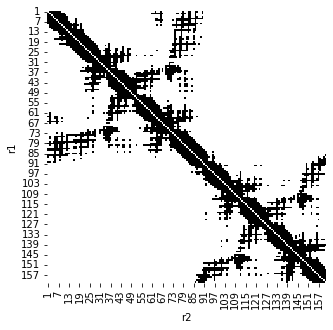

In [4]:
import pcmap

def contact_matrix(pdb_fname, **kwargs):
    cmap = pcmap.contactMap(pdb_fname, **kwargs)
    cmat =  []
    for ctct in cmap['data']:
        for pt in ctct['partners']:
            cmat.append([int(ctct['root']['resID']), int(pt['resID']), 1])
            cmat.append([int(pt['resID']), int(ctct['root']['resID']), 1])
    cmat = pd.DataFrame(cmat, columns=['r1', 'r2', 'contact']).pivot(index='r1', columns='r2', values='contact').fillna(0)
    return cmat

plt.figure(figsize=(5,5))
sns.heatmap(contact_matrix("structures/TNNC1.pdb", dist=10), cmap='Greys', cbar=False)

BAG3


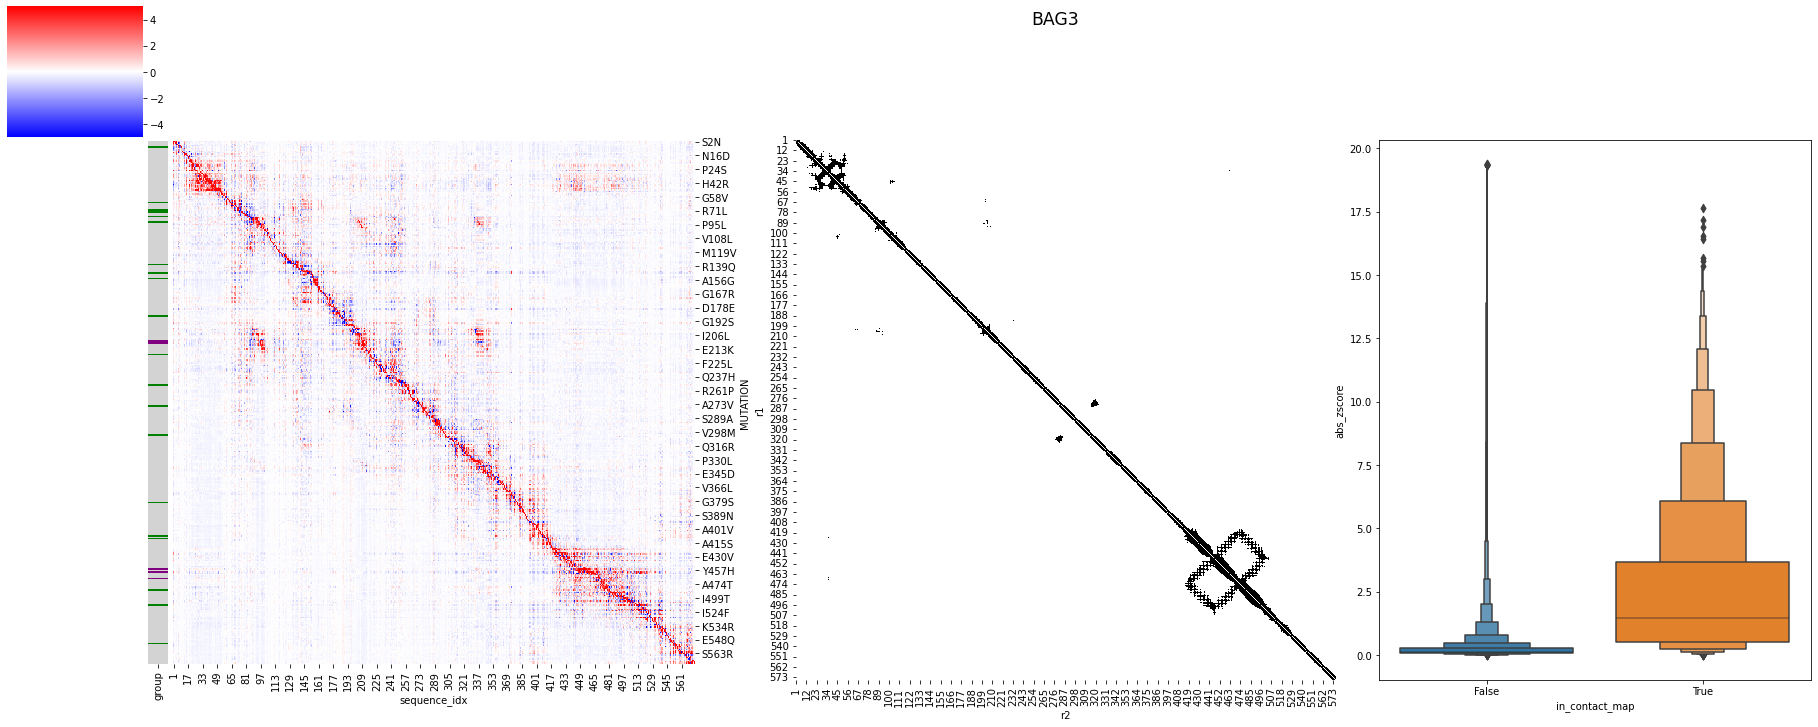

In [17]:
import os
from scipy.stats.stats import zscore
    
def plot_muts(fname):
    mutscores_df = pd.read_csv(fname, sep='\t')
    gene = mutscores_df['GENE'].values[0]
    cmat = contact_matrix(f"structures/{gene}.pdb", dist=10)
    mutscores_df = mutscores_df.assign(
        wt_residue=lambda df:df['MUTATION'].apply(lambda x: x[0]),
        mut_idx=lambda df:df['MUTATION'].apply(lambda x: int(x[1:-1])),
    )
    mutscores_df = mutscores_df[ (mutscores_df['residue'].isin(aminoacids))]
    mutscores_df.sort_values('score')
    variant_to_group = mutscores_df.drop_duplicates(['MUTATION', 'GROUP']).set_index('MUTATION')['GROUP'].to_dict()
    variant_colors = {'VUS':'lightgray', 'P/LP':'purple', 'B/LB':'green', 'Other':'yellow'}
    #plt.figure(figsize=(22, len(mutscores_df['MUTATION'].unique()) * 0.5))
    mat = (mutscores_df
              .groupby(['MUTATION', 'sequence_idx'])['score'].mean()
              .reset_index()
              .pivot(index='MUTATION', columns='sequence_idx', values='score')
              .assign(mut_idx=lambda df:df.index.map(lambda x: int(x[1:-1])), group=lambda df:df.index.map(lambda x: variant_to_group[x]))
              .sort_values('mut_idx')
              .drop('mut_idx', axis=1)
             )
    zs_mat = mat.drop('group', axis=1).apply(zscore, axis=0)
    zs_mat_flat = zs_mat.melt(value_name='zscore', ignore_index=False).assign(mut_idx=lambda df:df.index.map(lambda x: int(x[1:-1])))
    
    g = sns.clustermap(
        data=zs_mat,
        cmap='bwr',
        vmax=5,
        vmin=-5,
        col_cluster=False,
        row_cluster=False,
        row_colors=mat['group'].apply(lambda x: variant_colors[x]),
    )
    zs_mat_flat['in_contact_map'] = zs_mat_flat.apply(
        lambda df:
        cmat.loc[df['sequence_idx'], df['mut_idx']] == 1
        if df['sequence_idx'] in cmat.index.values and df['mut_idx'] in cmat.columns
        else 0
        , axis=1)
    zs_mat_flat['abs_zscore'] = abs(zs_mat_flat['zscore'])
    g.fig.set_size_inches(30, 10)
    g.fig.subplots_adjust(right=1/3.)
    ax1 = g.fig.add_axes([0.38, 0.05, 0.25, 0.75])
    sns.heatmap(cmat, cmap='Greys', cbar=False, ax=ax1)
    ax2 = g.fig.add_axes([0.65, 0.05, 0.2, 0.75])
    sns.boxenplot(data=zs_mat_flat, x='in_contact_map', y='abs_zscore', ax=ax2)
    plt.suptitle(gene, fontsize='xx-large')
    plt.savefig(f"figures/{gene}_heatmap_cmap.png")
    
    del zs_mat
    del zs_mat_flat
    del mat
    del mutscores_df
    del cmat

dr = 'results_esm1_1_vs_wt/'
for fname in os.listdir(dr):
    if fname.endswith('.tsv') and fname.startswith('mutscan'):
        gene = fname.replace('mutscan_', '').replace('.tsv', '')
        if gene in ['PMS2', 'MSH2']:
            continue
        if gene not in ['BAG3']:
            continue
        print(gene)
        plot_muts(dr + fname)

        
